# Basics on integrating ODE, adjoint method, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cpu


### 1- Solving an ODE

Assume the following ODE (Lorenz attractor)

\begin{align}
    \begin{matrix}
        \frac{dx}{dt} \\ \frac{dy}{dt} \\ \frac{dz}{dt}
    \end{matrix} &=
    \begin{matrix}
        \sigma \left( y(t) - x(t) \right) \\
        \rho x(t) - y(t) - x(t)z(t) \\
        x(t)y(t) - \beta z(t)
    \end{matrix}
\end{align}

with $\sigma, \rho, \beta > 0$.

In [3]:
sigma = 10
beta = 8/3
rho = 28

def func(t, vec):
    # signature of func must be func(t, y)
    x, y, z = vec
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return x_dot, y_dot, z_dot

x0 = [1.0, 1.0, 1.0]

t_start = 0.0
t_end = 40.0
t_span = (t_start, t_end)

In [4]:
from scipy.integrate import solve_ivp
import numpy as np

t_eval = np.linspace(t_start, t_end, 10000)

sol = solve_ivp(func, t_span, x0, t_eval=t_eval)

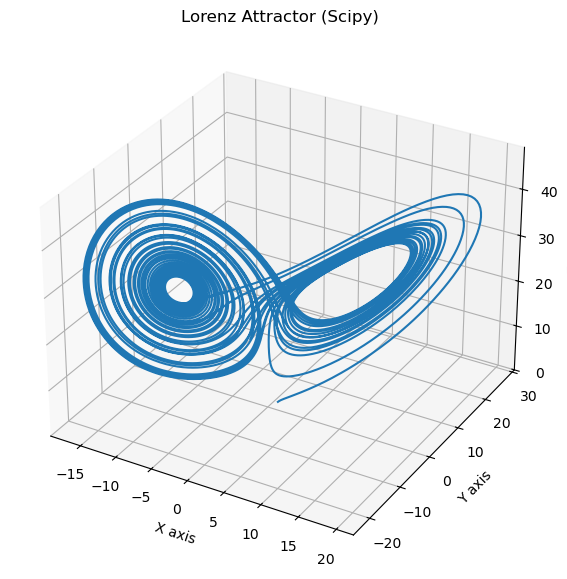

In [5]:
# plot results in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 7))
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("Lorenz Attractor (Scipy)")
plt.show()

### 2- Solveur maison

In [6]:
def t_func(t, vec):
    # signature of func must be func(t, y)
    x, y, z = vec[0], vec[1], vec[2]
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return torch.stack([x_dot, y_dot, z_dot])

In [7]:
def t_solve_ivp(func, t_span, x0, nsteps=10000, method='RK4'):
    """
    Home made ODE solver to work with tensors.
    Inputs:
        - func : function of the ODE, signature func(t, y)
            - t : float
            - y : tensor of shape (n,)
        - t_span : tuple of floats (t0, tf), starting and end times
        - x0 : tensor of shape (n,), staring value
    """
    t_start, t_end = t_span
    dt = (t_end - t_start) / nsteps
    t = t_start
    ts = [t_start + i*dt for i in range(nsteps+1)]
    xs = [x0.clone().to(device)]
    dxs = []
    x = x0.clone().to(device).requires_grad_(True)
    
    assert method in ['Euler', 'RK4'], "Method must be 'Euler' or 'RK4'"

    for _ in range(nsteps):
        if method == 'Euler':
            # Euler step
            dx = func(t, x)
            x = x + dx * dt
            t = t + dt
        elif method == 'RK4':
            # Runge Kutta 4th order step
            k1 = func(t, x)
            k2 = func(t + dt/2, x + dt/2 * k1)
            k3 = func(t + dt/2, x + dt/2 * k2)
            k4 = func(t + dt, x + dt * k3)
            dx = dt/6 * (k1 + 2*k2 + 2*k3 + k4)
            x = x + dx
            t = t + dt
        xs.append(x)
        dxs.append(dx)
        
    _ = xs.pop(0)  # remove initial condition to match solve_ivp output
    ts = torch.tensor(ts, dtype=torch.float32, requires_grad=True).to(device)
    sols = torch.stack(xs)
    grads = torch.stack(dxs)
        
    return ts, sols, grads

In [34]:
x0 = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float, requires_grad=True)
ts, sols, grads =  t_solve_ivp(t_func, t_span, x0, nsteps=1000, method='RK4')

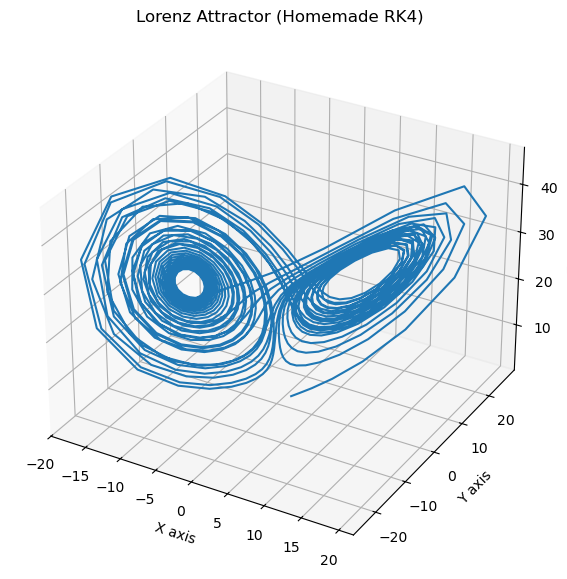

In [35]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 7))
ax.plot(
    sols[:,0].detach().cpu().numpy(), 
    sols[:,1].detach().cpu().numpy(), 
    sols[:,2].detach().cpu().numpy()
)
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("Lorenz Attractor (Homemade RK4)")
plt.show()

### 3- Model with parameters

In [36]:
class ODENet(nn.Module):
    def __init__(self, n=64):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, n),
            nn.Tanh(),
            nn.Linear(n, 3)
        )
    def forward(self, x):
        return self.net(x)
    
ode_net = ODENet(n=64).to(device)

In [56]:
# .clone() to make a copy of the data, keeps the computation graph history from the original tensor
# TORCH DOC : This function is differentiable, so gradients will flow back from the result of this operation to input.

# .detach() to break the computation graph, no gradient will be computed for this tensor
# TORCH DOC : 
# - Returns a new Tensor, detached from the current graph.
# - The result will never require gradient.
# - Returned Tensor shares the same storage with the original one. In-place modifications on either of them will be seen, and may trigger errors in correctness checks.

# .requires_grad_(True) to tell PyTorch to track operations on this tensor for gradient computation

x = sols.clone().detach().to(device).requires_grad_(True)
targets = grads.clone().detach().to(device)

y = ode_net(x)

In [60]:
loss = (y - targets).pow(2).mean()
loss.backward()

y : requires_grad = True, grad_fn = <AddmmBackward0 object at 0x7f1f84d21540>
targets : requires_grad = False, grad_fn = None
loss : requires_grad = True, grad_fn = <MeanBackward0 object at 0x7f1f84d215d0>
net.0.weight: requires_grad=True, shape=torch.Size([64, 3])
net.0.bias: requires_grad=True, shape=torch.Size([64])
net.2.weight: requires_grad=True, shape=torch.Size([3, 64])
net.2.bias: requires_grad=True, shape=torch.Size([3])


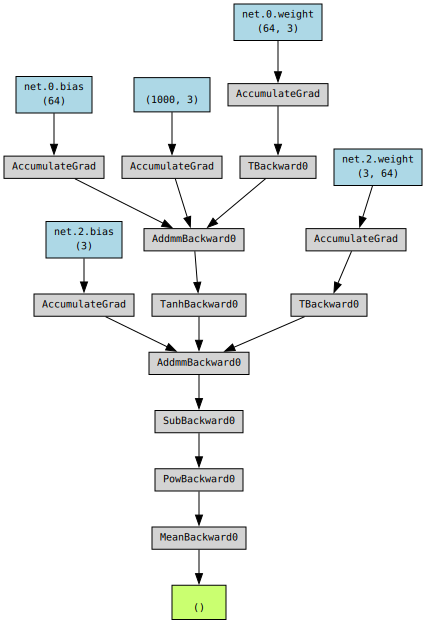

In [61]:
from torchviz import make_dot

# params
print(f"y : requires_grad = {y.requires_grad}, grad_fn = {y.grad_fn}")
print(f"targets : requires_grad = {targets.requires_grad}, grad_fn = {targets.grad_fn}")
print(f"loss : requires_grad = {loss.requires_grad}, grad_fn = {loss.grad_fn}")

# For each parameter:
for name, param in ode_net.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}, shape={param.shape}")

make_dot(l, params=dict(ode_net.named_parameters()))

### 3- Form adjoint ODE:

\begin{align}
    \frac{d\lambda}{dt} &= - \left( \frac{\partial f}{\partial u} \right)^T \lambda + \left( \frac{\partial g}{\partial u} \right)^T
\end{align}